In [53]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
from IPython.display import clear_output

Buscar valores faltantes y outliers en las tablas de ventas,
compras y gastos. Al encontrarlos, mostrar una gráfica que
permita analizar la calidad del dato, por último deberás
corregirlos o desestimarlos.

In [55]:
venta = pd.read_csv('Datasets/Venta.csv')

In [56]:
venta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46645 entries, 0 to 46644
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   IdVenta        46645 non-null  int64  
 1   Fecha          46645 non-null  object 
 2   Fecha_Entrega  46645 non-null  object 
 3   IdCanal        46645 non-null  int64  
 4   IdCliente      46645 non-null  int64  
 5   IdSucursal     46645 non-null  int64  
 6   IdEmpleado     46645 non-null  int64  
 7   IdProducto     46645 non-null  int64  
 8   Precio         45721 non-null  float64
 9   Cantidad       45753 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 3.6+ MB


In [57]:
def evaluacion_calidad_outliers(dato, desde, hasta):
    calidad = 'Sin errores'
    if (str(dato) == 'nan'):
        calidad = 'Valor Nulo'
        return calidad
    if ((dato < desde) or (dato > hasta)):
        calidad = 'Outlier'
        return calidad
    return calidad

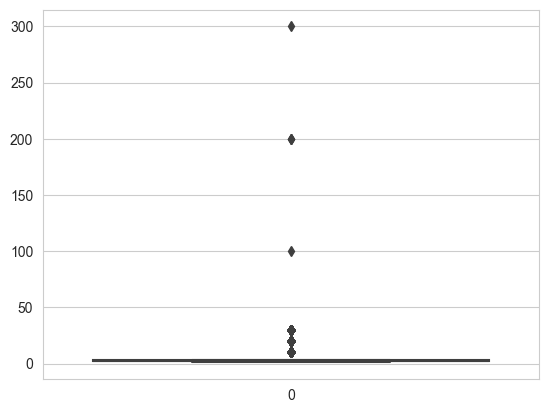

In [58]:
sns.boxplot(venta.Cantidad)
plt.show()

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\1968963712.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(venta.Precio ,hist=True, kde=True, rug=True)


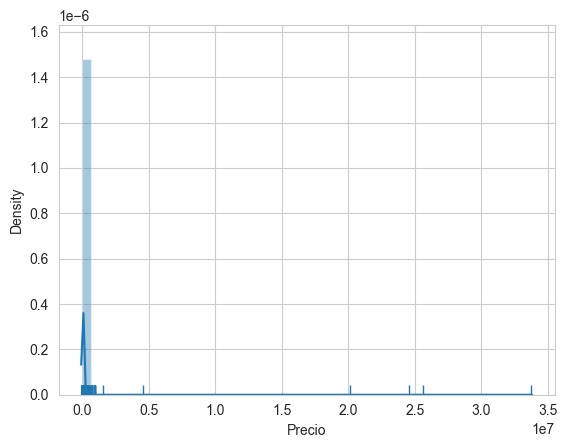

In [59]:
sns.distplot(venta.Precio ,hist=True, kde=True, rug=True)
plt.show()

Se buscan los Outliers pero agrupando por IdProducto

In [60]:
lista_id_producto = []
lista_min_precio = []
lista_max_precio = []
lista_min_cantidad = []
lista_max_cantidad = []
i_max = len(venta.IdProducto.unique())
i = 0
for id_producto in venta.IdProducto.unique():
    i = i + 1
    q1 = venta[venta['IdProducto'] == id_producto].Precio.quantile(0.25)
    mediana = venta[venta['IdProducto'] == id_producto].Precio.quantile(0.5)
    #mediana = df_venta[df_venta['IdProducto'] == id_producto].Precio.median()
    q3 = venta[venta['IdProducto'] == id_producto].Precio.quantile(0.75)
    iqr = q3 - q1
    min_precio = mediana - 1.5 * iqr
    max_precio = mediana + 1.5 * iqr    
    if (min_precio < 0.001):
        min_precio = 0.001
    
    q1 = venta[venta['IdProducto'] == id_producto].Cantidad.quantile(0.25)
    mediana = venta[venta['IdProducto'] == id_producto].Cantidad.quantile(0.5)
    #mediana = df_venta[df_venta['IdProducto'] == id_producto].Cantidad.median()
    q3 = venta[venta['IdProducto'] == id_producto].Cantidad.quantile(0.75)
    iqr = q3 - q1
    min_cantidad = mediana - 1.5 * iqr
    max_cantidad = mediana + 1.5 * iqr  
    if (min_cantidad < 0):
        min_cantidad = 0
    
    lista_id_producto.append(id_producto)
    lista_min_precio.append(min_precio)
    lista_max_precio.append(max_precio)
    lista_min_cantidad.append(min_cantidad)
    lista_max_cantidad.append(max_cantidad)
    
    clear_output(wait=True)
    print('Completado: ' + str(round(i / i_max * 100, 2)) + '%')

Completado: 100.0%


In [61]:
lst = list(zip(lista_id_producto, lista_min_precio, lista_max_precio, lista_min_cantidad, lista_max_cantidad))
venta_outliers = pd.DataFrame(lst , columns = ['IdProducto','MinPrecio','MaxPrecio','MinCantidad', 'MaxCantidad'])

In [62]:
venta = pd.merge(venta, venta_outliers, on='IdProducto', how='left')

In [63]:
venta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46645 entries, 0 to 46644
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   IdVenta        46645 non-null  int64  
 1   Fecha          46645 non-null  object 
 2   Fecha_Entrega  46645 non-null  object 
 3   IdCanal        46645 non-null  int64  
 4   IdCliente      46645 non-null  int64  
 5   IdSucursal     46645 non-null  int64  
 6   IdEmpleado     46645 non-null  int64  
 7   IdProducto     46645 non-null  int64  
 8   Precio         45721 non-null  float64
 9   Cantidad       45753 non-null  float64
 10  MinPrecio      46645 non-null  float64
 11  MaxPrecio      46645 non-null  float64
 12  MinCantidad    46645 non-null  float64
 13  MaxCantidad    46645 non-null  float64
dtypes: float64(6), int64(6), object(2)
memory usage: 5.3+ MB


In [64]:
venta['Calidad_Precio'] = venta.apply(lambda row: evaluacion_calidad_outliers(row['Precio'], row['MinPrecio'], row['MaxPrecio']), axis=1)

In [65]:
venta['Calidad_Cantidad'] = venta.apply(lambda row: evaluacion_calidad_outliers(row['Cantidad'], row['MinCantidad'], row['MaxCantidad']), axis=1)

In [66]:
def ploteo_Calidad(df, columna, ubicacion):
    """
    Esta función recibe de parámetros un objeto dataframe y el nombre de la columna por la cuál se va a realizar el gráfico
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    test_per = df.groupby(columna).agg(Porcentage =(columna, lambda p: p.count() / df[columna].count() * 100)).round(2)
    sns.set_style("whitegrid")
    bar,ax = plt.subplots(figsize=(10,6))
    ax = sns.barplot(x=test_per.index, y='Porcentage', data=test_per, ci=None, palette="muted",orient='v', )
    ax.set_title(columna, fontsize=15)
    ax.set_xlabel ("Estado")
    ax.set_ylabel ("Porcentage")
    # calculate the percentages and annotate the sns barplot
    for rect in ax.patches:
        ax.text (rect.get_x() + rect.get_width() / 2,rect.get_height(),"%.1f%%"% rect.get_height(), weight='bold' )
    #bar.savefig(ubicacion + '\\' + columna + ".png");
    plt.show()

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\2489231133.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=test_per.index, y='Porcentage', data=test_per, ci=None, palette="muted",orient='v', )


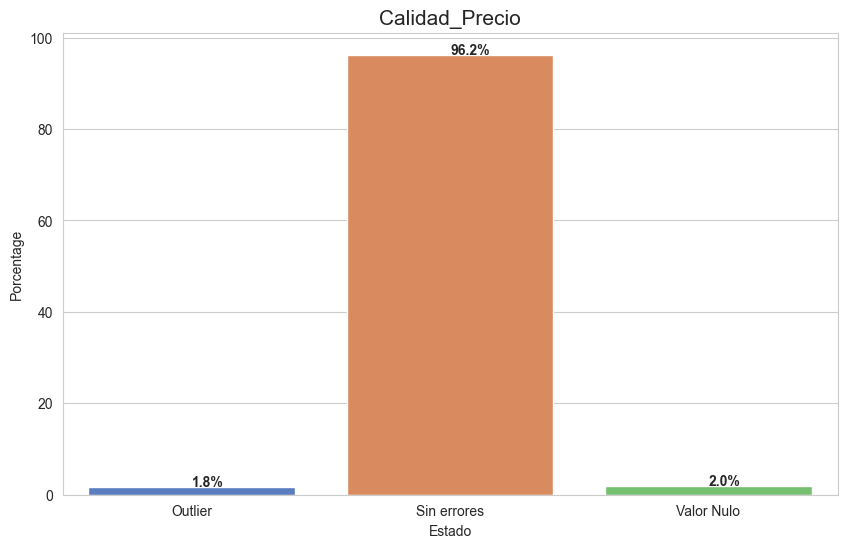

In [67]:
ploteo_Calidad(venta, 'Calidad_Precio', '')

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\2489231133.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=test_per.index, y='Porcentage', data=test_per, ci=None, palette="muted",orient='v', )


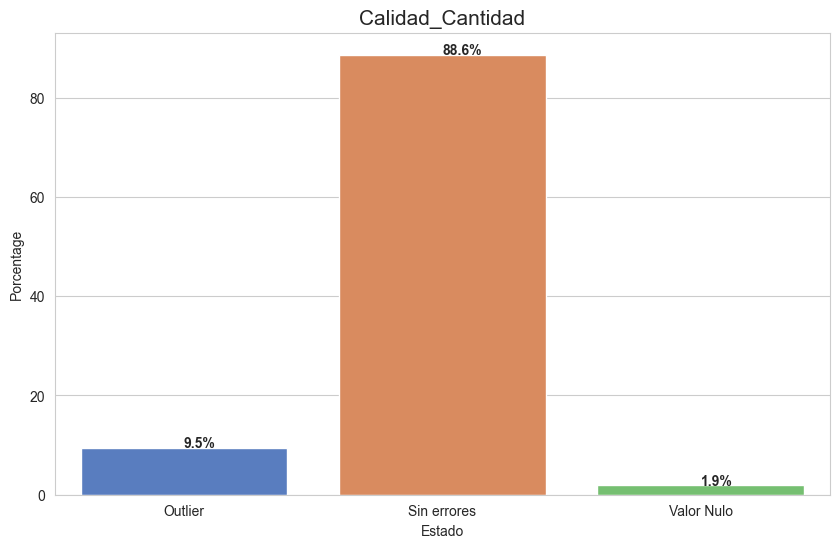

In [68]:
ploteo_Calidad(venta, 'Calidad_Cantidad', '')

In [69]:
compra = pd.read_csv("Datasets/Compra.csv", sep=",")

In [71]:
compra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11539 entries, 0 to 11538
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IdCompra     11539 non-null  int64  
 1   Fecha        11539 non-null  object 
 2   IdProducto   11539 non-null  int64  
 3   Cantidad     11539 non-null  int64  
 4   Precio       11172 non-null  float64
 5   IdProveedor  11539 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 541.0+ KB


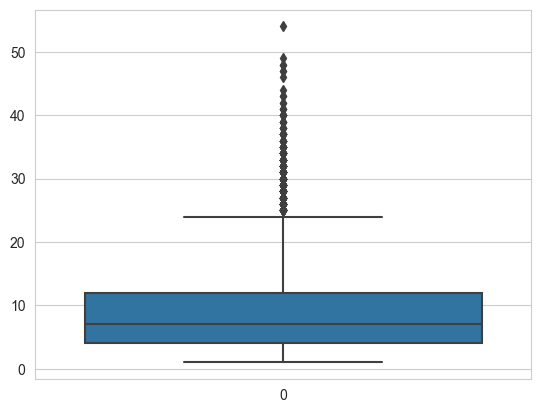

In [72]:
sns.boxplot(compra.Cantidad)
plt.show()

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\3900285494.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(compra.Cantidad, hist=True, kde=True, rug=True)


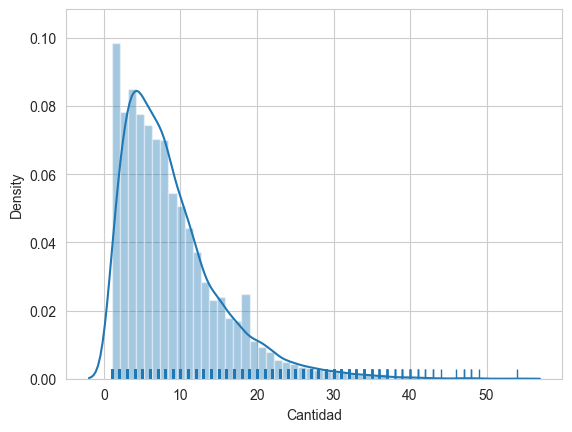

In [73]:
sns.distplot(compra.Cantidad, hist=True, kde=True, rug=True)
plt.show()

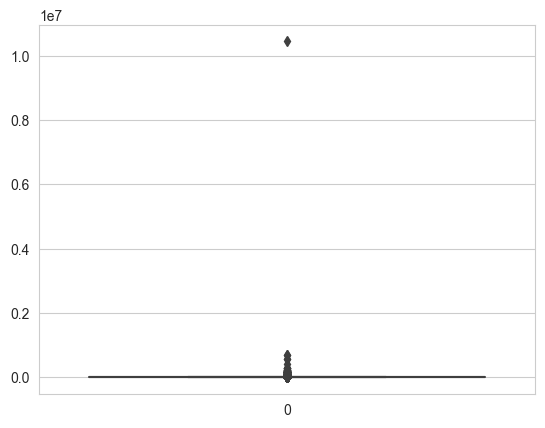

In [74]:
sns.boxplot(compra.Precio)
plt.show()

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\2863623396.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(compra.Precio, hist=True, kde=True, rug=True)


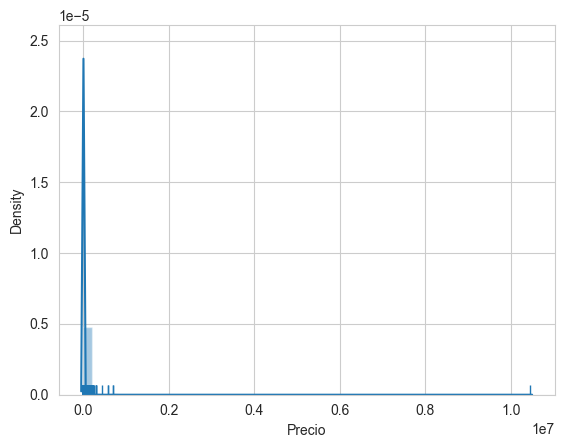

In [75]:
sns.distplot(compra.Precio, hist=True, kde=True, rug=True)
plt.show()

In [76]:
lista_id_producto = []
lista_min_precio = []
lista_max_precio = []
lista_min_cantidad = []
lista_max_cantidad = []
i_max = len(compra.IdProducto.unique())
i = 0
for id_producto in compra.IdProducto.unique():
    i = i + 1
    q1 = compra[compra['IdProducto'] == id_producto].Precio.quantile(0.25)
    mediana = compra[compra['IdProducto'] == id_producto].Precio.quantile(0.5)
    #mediana = df_compra[df_compra['IdProducto'] == id_producto].Precio.median()
    q3 = compra[compra['IdProducto'] == id_producto].Precio.quantile(0.75)
    iqr = q3 - q1
    min_precio = mediana - 1.5 * iqr
    max_precio = mediana + 1.5 * iqr    
    if (min_precio < 0.001):
        min_precio = 0.001
    
    q1 = compra[compra['IdProducto'] == id_producto].Cantidad.quantile(0.25)
    mediana = compra[compra['IdProducto'] == id_producto].Cantidad.quantile(0.5)
    #mediana = df_compra[df_compra['IdProducto'] == id_producto].Cantidad.median()
    q3 = compra[compra['IdProducto'] == id_producto].Cantidad.quantile(0.75)
    iqr = q3 - q1
    min_cantidad = mediana - 1.5 * iqr
    max_cantidad = mediana + 1.5 * iqr  
    if (min_cantidad < 0):
        min_cantidad = 0
    
    lista_id_producto.append(id_producto)
    lista_min_precio.append(min_precio)
    lista_max_precio.append(max_precio)
    lista_min_cantidad.append(min_cantidad)
    lista_max_cantidad.append(max_cantidad)
    
    clear_output(wait=True)
    print('Completado: ' + str(round(i / i_max * 100, 2)) + '%')

Completado: 100.0%


In [77]:
lst = list(zip(lista_id_producto, lista_min_precio, lista_max_precio, lista_min_cantidad, lista_max_cantidad))
compra_outliers = pd.DataFrame(lst , columns = ['IdProducto','MinPrecio','MaxPrecio','MinCantidad', 'MaxCantidad'])

In [78]:
compra = pd.merge(compra, compra_outliers, on='IdProducto', how='left')

In [79]:
compra['Calidad_Precio'] = compra.apply(lambda row: evaluacion_calidad_outliers(row['Precio'], row['MinPrecio'], row['MaxPrecio']), axis=1)

In [80]:
compra['Calidad_Cantidad'] = compra.apply(lambda row: evaluacion_calidad_outliers(row['Cantidad'], row['MinCantidad'], row['MaxCantidad']), axis=1)

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\2489231133.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=test_per.index, y='Porcentage', data=test_per, ci=None, palette="muted",orient='v', )


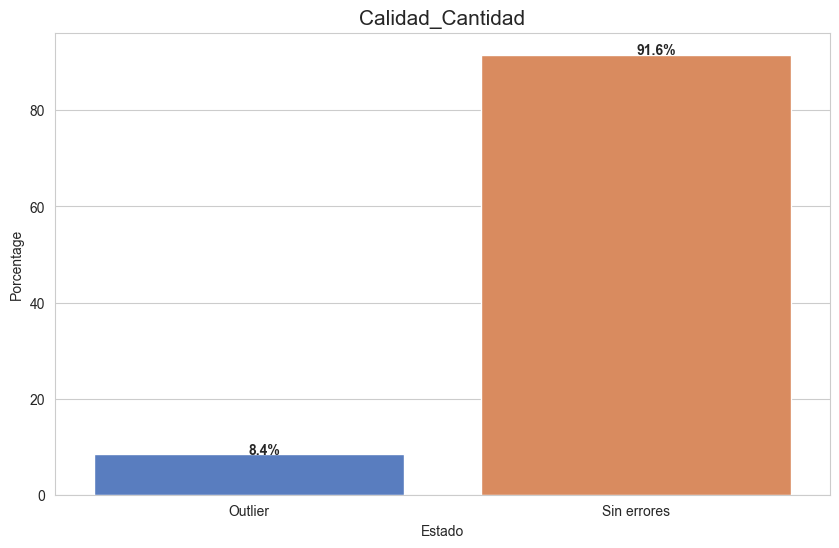

In [81]:
ploteo_Calidad(compra, 'Calidad_Cantidad', '')

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\2489231133.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=test_per.index, y='Porcentage', data=test_per, ci=None, palette="muted",orient='v', )


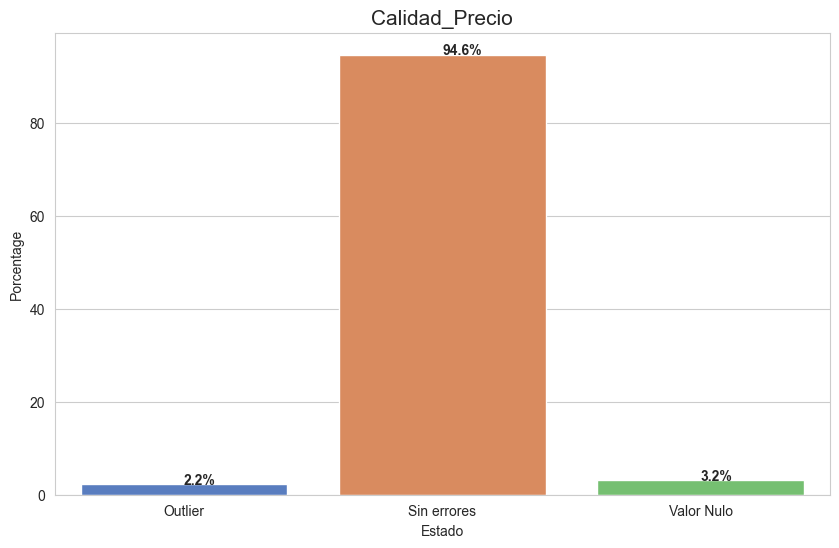

In [82]:
ploteo_Calidad(compra, 'Calidad_Precio', '')

In [83]:
gasto = pd.read_csv("Datasets/Gasto.csv", sep=",")

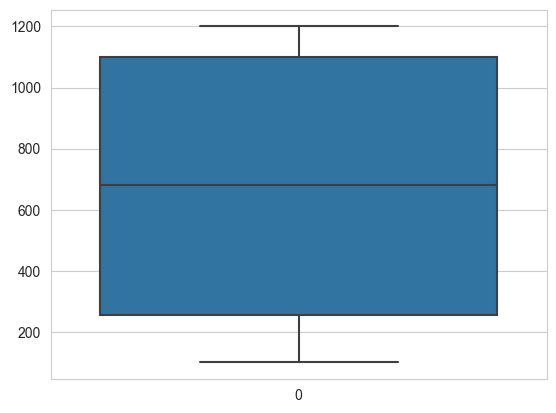

In [84]:
sns.boxplot(gasto.Monto)
plt.show()

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\3841854257.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gasto.Monto, hist=True, kde=True, rug=True)


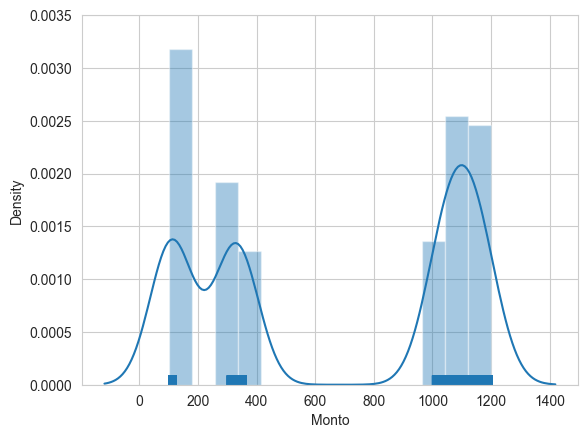

In [85]:
sns.distplot(gasto.Monto, hist=True, kde=True, rug=True)
plt.show()

In [86]:
lista_id_tipo_gasto = []
lista_min_monto = []
lista_max_monto = []
i_max = len(gasto.IdTipoGasto.unique())
i = 0
for id_tipo_gasto in gasto.IdTipoGasto.unique():
    i = i + 1
    q1 = gasto[gasto['IdTipoGasto'] == id_tipo_gasto].Monto.quantile(0.25)
    mediana = gasto[gasto['IdTipoGasto'] == id_tipo_gasto].Monto.quantile(0.5)
    #mediana = df_gasto[df_gasto['IdTipoGasto'] == id_tipo_gasto].Monto.median()
    q3 = gasto[gasto['IdTipoGasto'] == id_tipo_gasto].Monto.quantile(0.75)
    iqr = q3 - q1
    min_monto = mediana - 1.5 * iqr
    max_monto = mediana + 1.5 * iqr    
    if (min_monto < 0.001):
        min_monto = 0.001
    
    lista_id_tipo_gasto.append(id_tipo_gasto)
    lista_min_monto.append(min_monto)
    lista_max_monto.append(max_monto)
    
    clear_output(wait=True)
    print('Completado: ' + str(round(i / i_max * 100, 2)) + '%')

Completado: 100.0%


In [91]:
lst = list(zip(lista_id_tipo_gasto, lista_min_monto, lista_max_monto))
gasto_outliers = pd.DataFrame(lst , columns = ['IdTipoGasto','MinMonto','MaxMonto'])

In [94]:
gasto = pd.merge(gasto, gasto_outliers, on='IdTipoGasto', how='left')

In [95]:
gasto['Calidad_Monto'] = gasto.apply(lambda row: evaluacion_calidad_outliers(row['Monto'], row['MinMonto'], row['MaxMonto']), axis=1)

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\2489231133.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=test_per.index, y='Porcentage', data=test_per, ci=None, palette="muted",orient='v', )


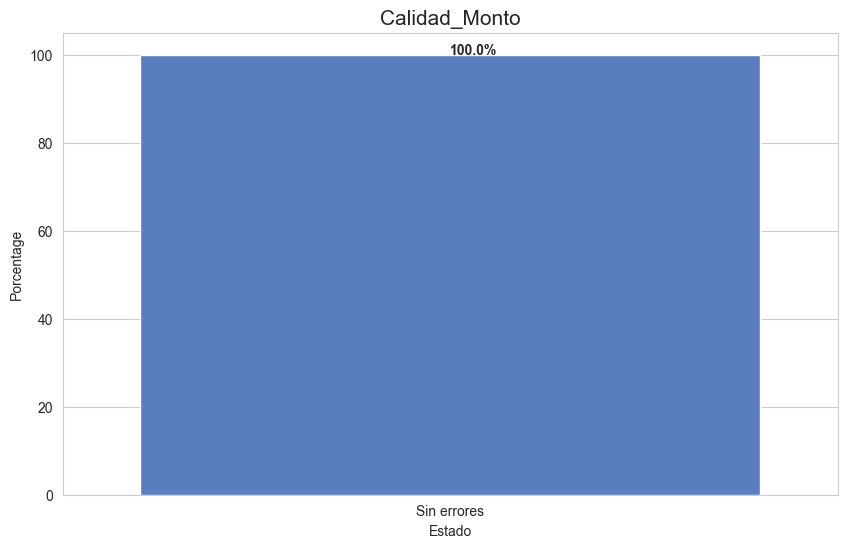

In [96]:
ploteo_Calidad(gasto, 'Calidad_Monto', '')

In [97]:
venta['Venta'] = venta['Precio'] * venta['Cantidad']
compra['Compra'] = compra['Precio'] * compra['Cantidad']

In [98]:
venta_fecha = venta[(venta['Calidad_Precio'] == 'Sin errores') & (venta['Calidad_Cantidad'] == 'Sin errores')].groupby(["Fecha"])["Venta"].sum()
compra_fecha = compra[(compra['Calidad_Precio'] == 'Sin errores') & (compra['Calidad_Cantidad'] == 'Sin errores')].groupby(["Fecha"])["Compra"].sum()

In [99]:
venta_fecha = pd.DataFrame(venta_fecha)
compra_fecha = pd.DataFrame(compra_fecha)

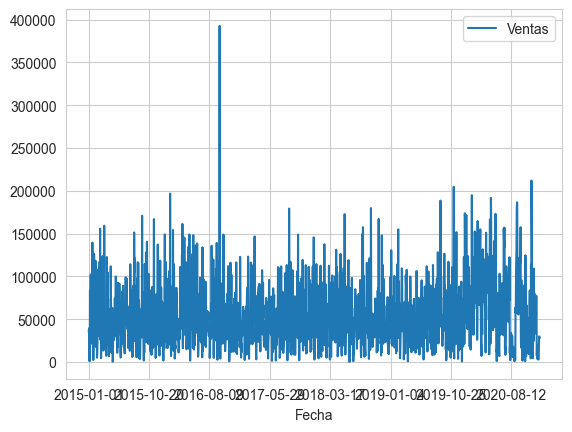

In [100]:
venta_fecha['Venta'].plot(legend=True)
#df_compra_fecha['Compra'].plot(legend=True)
#plt.legend(['Ventas', 'Compras'])
plt.legend(['Ventas'])
plt.show()

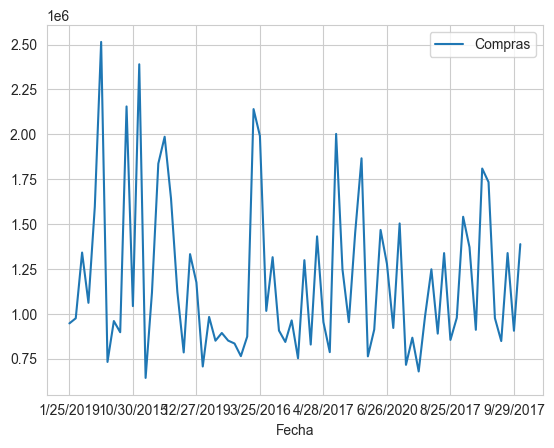

In [101]:
compra_fecha['Compra'].plot(legend=True)
plt.legend(['Compras'])
plt.show()

In [102]:
venta['Fecha']=pd.to_datetime(venta['Fecha'], format='%Y-%m-%d')
venta['Fecha_Entrega']=pd.to_datetime(venta['Fecha_Entrega'], format='%Y-%m-%d')

In [103]:
venta['Fecha_Año'] = pd.DatetimeIndex(venta['Fecha']).year
venta['Fecha_Mes'] = pd.DatetimeIndex(venta['Fecha']).month
venta['Fecha_Periodo'] = venta['Fecha_Año'] * 100 + venta['Fecha_Mes']

In [104]:
compra['Fecha']=pd.to_datetime(compra['Fecha'], format='%m/%d/%Y')
gasto['Fecha']=pd.to_datetime(gasto['Fecha'], format='%Y-%m-%d')

In [105]:
compra['Fecha_Año'] = pd.DatetimeIndex(compra['Fecha']).year
compra['Fecha_Mes'] = pd.DatetimeIndex(compra['Fecha']).month
compra['Fecha_Periodo'] = compra['Fecha_Año'] * 100 + compra['Fecha_Mes']

In [106]:
gasto['Fecha_Año'] = pd.DatetimeIndex(gasto['Fecha']).year
gasto['Fecha_Mes'] = pd.DatetimeIndex(gasto['Fecha']).month
gasto['Fecha_Periodo'] = gasto['Fecha_Año'] * 100 + gasto['Fecha_Mes']

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\3057069672.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data = venta[(venta['Calidad_Precio'] == 'Sin errores') & (venta['Calidad_Cantidad'] == 'Sin errores')], x = "Fecha_Año", y = "Venta", estimator=sum, ci=None)


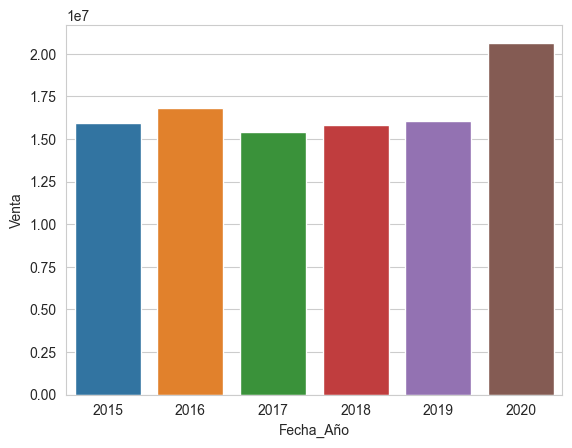

In [107]:
sns.barplot(data = venta[(venta['Calidad_Precio'] == 'Sin errores') & (venta['Calidad_Cantidad'] == 'Sin errores')], x = "Fecha_Año", y = "Venta", estimator=sum, ci=None)
plt.show()

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\210072285.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data = venta[(venta['Calidad_Precio'] == 'Sin errores') & (venta['Calidad_Cantidad'] == 'Sin errores') & (venta['Fecha_Año'] == 2020)], x = "Fecha_Mes", y = "Venta", estimator=sum, ci=None)


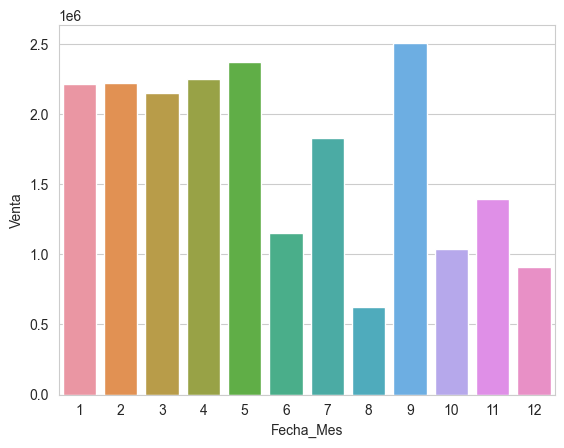

In [108]:
sns.barplot(data = venta[(venta['Calidad_Precio'] == 'Sin errores') & (venta['Calidad_Cantidad'] == 'Sin errores') & (venta['Fecha_Año'] == 2020)], x = "Fecha_Mes", y = "Venta", estimator=sum, ci=None)
plt.show()

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\2302624901.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data = compra[(compra['Calidad_Precio'] == 'Sin errores') & (compra['Calidad_Cantidad'] == 'Sin errores')], x = "Fecha_Año", y = "Compra", estimator=sum, ci=None)


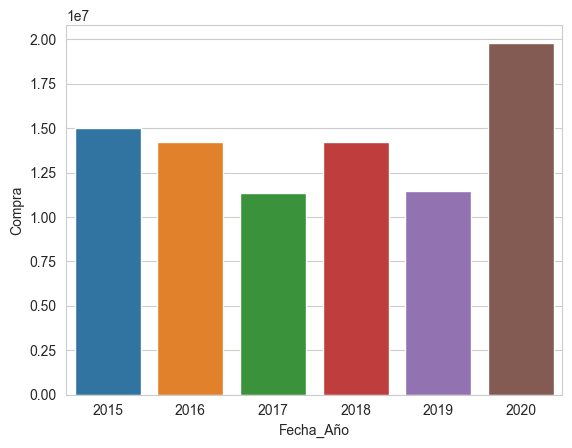

In [109]:
sns.barplot(data = compra[(compra['Calidad_Precio'] == 'Sin errores') & (compra['Calidad_Cantidad'] == 'Sin errores')], x = "Fecha_Año", y = "Compra", estimator=sum, ci=None)
plt.show()

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\1978691584.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data =  compra[(compra['Calidad_Precio'] == 'Sin errores') & (compra['Calidad_Cantidad'] == 'Sin errores') & (compra['Fecha_Año'] == 2020)], x = "Fecha_Mes", y = "Compra", estimator=sum, ci=None)


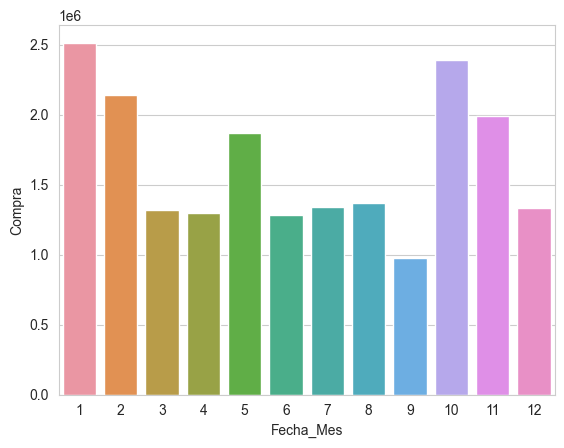

In [110]:
sns.barplot(data =  compra[(compra['Calidad_Precio'] == 'Sin errores') & (compra['Calidad_Cantidad'] == 'Sin errores') & (compra['Fecha_Año'] == 2020)], x = "Fecha_Mes", y = "Compra", estimator=sum, ci=None)
plt.show()

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\2014982663.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(venta[(venta['Calidad_Precio'] == 'Sin errores') & (venta['Calidad_Cantidad'] == 'Sin errores')].Cantidad, hist=True, kde=True, rug=True)


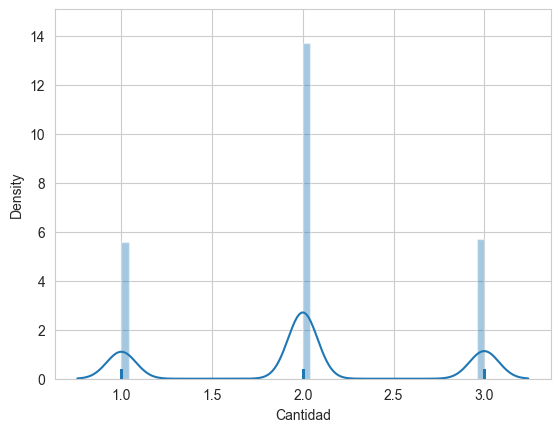

In [111]:
sns.distplot(venta[(venta['Calidad_Precio'] == 'Sin errores') & (venta['Calidad_Cantidad'] == 'Sin errores')].Cantidad, hist=True, kde=True, rug=True)
plt.show()

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\347534809.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(venta[(venta['Calidad_Precio'] == 'Sin errores') & (venta['Calidad_Cantidad'] == 'Sin errores')].Precio, hist=True, kde=True, rug=True)


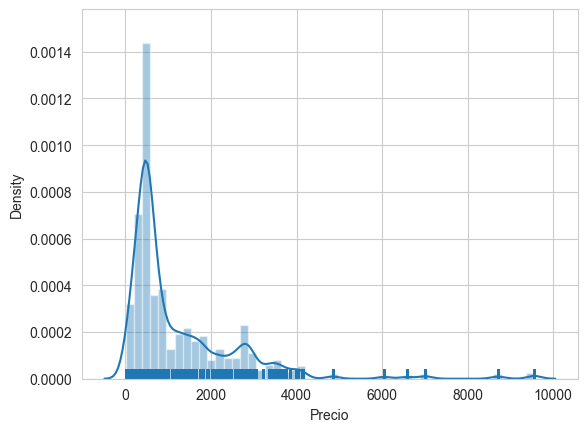

In [112]:
sns.distplot(venta[(venta['Calidad_Precio'] == 'Sin errores') & (venta['Calidad_Cantidad'] == 'Sin errores')].Precio, hist=True, kde=True, rug=True)
plt.show()

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\3412024615.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(compra[(compra['Calidad_Precio'] == 'Sin errores') & (compra['Calidad_Cantidad'] == 'Sin errores')].Cantidad, hist=True, kde=True, rug=True)


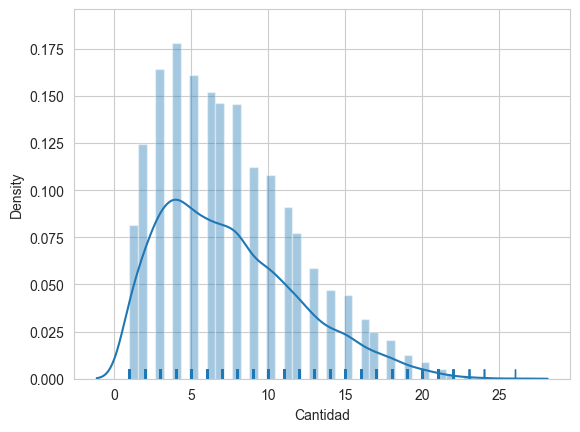

In [113]:
sns.distplot(compra[(compra['Calidad_Precio'] == 'Sin errores') & (compra['Calidad_Cantidad'] == 'Sin errores')].Cantidad, hist=True, kde=True, rug=True)
plt.show()

C:\Users\Emanu\AppData\Local\Temp\ipykernel_5688\2901133864.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(compra[(compra['Calidad_Precio'] == 'Sin errores') & (compra['Calidad_Cantidad'] == 'Sin errores')].Precio, hist=True, kde=True, rug=True)


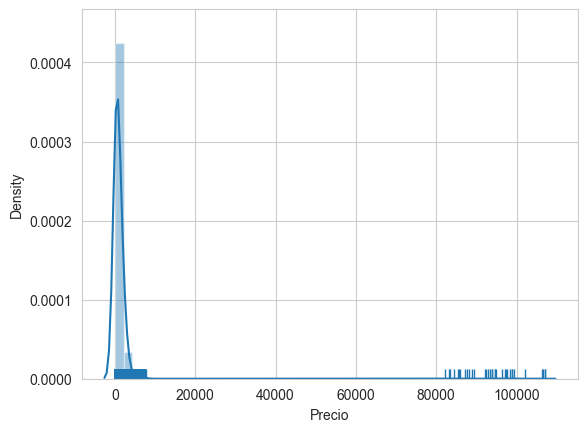

In [114]:
sns.distplot(compra[(compra['Calidad_Precio'] == 'Sin errores') & (compra['Calidad_Cantidad'] == 'Sin errores')].Precio, hist=True, kde=True, rug=True)
plt.show()

In [115]:
venta.to_csv('Datasets/Venta_Procesado.csv', index=False)
compra.to_csv('Datasets/Compra_Procesado.csv', index=False)
gasto.to_csv('Datasets/Gasto_Procesado.csv', index=False)